In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn import tree
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../Data/data.csv", sep=';')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
# identify column types
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric columns:", numeric_cols)
print('Length of numeric columns:', len(numeric_cols))

print("Categorical columns:", categorical_cols)
print('Length of categorical columns:', len(categorical_cols))

Numeric columns: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
Leng

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [5]:
df.isnull().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [6]:
df.duplicated().sum()

0

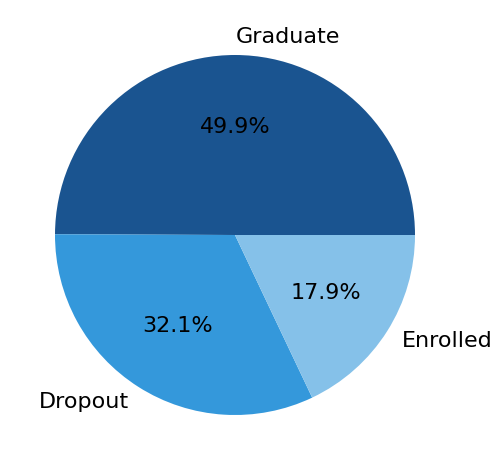

In [11]:
target = df['Target'].value_counts()
plt.pie(target, labels=target.index, autopct='%1.1f%%', textprops={'fontsize': 16}, colors=['#1a5490', '#3498db', '#85c1e9'])
plt.tight_layout()
plt.savefig("../Figures/target_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
# drop and assign back
df = df.drop('Nacionality', axis=1)
df = df.drop('Application mode', axis=1)

In [9]:
# mapping for previous qualification codes -> labels
pq_map = {
    1: 'Basic Education',
    2: 'Higher Education',
    3: 'Higher Education',
    4: 'Higher Education - Master or Doctorate',
    5: 'Higher Education - Master or Doctorate',
    6: 'Higher Education',
    9: 'Incomplete Basic Education',
    10: 'Incomplete Basic Education',
    12: 'Incomplete Basic Education',
    14: 'Incomplete Basic Education',
    15: 'Incomplete Basic Education',
    19: 'Incomplete Basic Education',
    38: 'Incomplete Basic Education',
    39: 'Technological Specialization Course',
    40: 'Higher Education',
    42: 'Higher Technical Course',
    43: 'Higher Education - Master or Doctorate',
}

# Safely map values (handles NaN and float codes)
def _map_prev_qual(x):
    if pd.isnull(x):
        return np.nan
    try:
        key = int(x)
    except Exception:
        return x
    return pq_map.get(key, np.nan)

df['Previous qualification'] = df['Previous qualification'].apply(_map_prev_qual)

# show counts including NaNs
# convert column to categorical dtype and show counts + dtype
df['Previous qualification'] = df['Previous qualification'].astype('category')
df["Previous qualification"].value_counts(dropna=False)
df['Previous qualification'].dtype

CategoricalDtype(categories=['Basic Education', 'Higher Education',
                  'Higher Education - Master or Doctorate',
                  'Higher Technical Course', 'Incomplete Basic Education',
                  'Technological Specialization Course'],
, ordered=False, categories_dtype=object)

In [10]:
# mapping for previous qualification codes -> labels
pq_map = {
    1: 'Basic Education',
    2: 'Higher Education',
    3: 'Higher Education',
    4: 'Higher Education - Master or Doctorate',
    5: 'Higher Education - Master or Doctorate',
    6: 'Higher Education',
    9: 'Incomplete Basic Education',
    10: 'Incomplete Basic Education',
    11: 'Incomplete Basic Education',
    12: 'Incomplete Basic Education',
    14: 'Incomplete Basic Education',
    18: 'General Course',
    19: 'Incomplete Basic Education',
    22: 'Technical Course',
    26: 'Incomplete Basic Education',
    27: 'Basic Education',
    29: 'Incomplete Basic Education',
    30: 'Incomplete Basic Education',
    34: 'Unknown',
    35: 'Iliterate',
    36: 'Incomplete Basic Education',
    37: 'Incomplete Basic Education',
    38: 'Incomplete Basic Education',
    39: 'Technological Specialization Course',
    40: 'Higher Education',
    41: 'Higher Education',
    42: 'Higher Technical Course',
    43: 'Higher Education - Master or Doctorate',
    44: 'Higher Education - Master or Doctorate',
}

# Safely map values (handles NaN and float codes)
def _map_prev_qual(x):
    if pd.isnull(x):
        return np.nan
    try:
        key = int(x)
    except Exception:
        return x
    return pq_map.get(key, np.nan)

df['Mother\'s qualification'] = df['Mother\'s qualification'].apply(_map_prev_qual)

# show counts including NaNs
df['Mother\'s qualification'] = df['Mother\'s qualification'].astype('category')
df["Mother's qualification"].value_counts(dropna=False)
df['Mother\'s qualification'].dtype

CategoricalDtype(categories=['Basic Education', 'General Course', 'Higher Education',
                  'Higher Education - Master or Doctorate',
                  'Higher Technical Course', 'Iliterate',
                  'Incomplete Basic Education', 'Technical Course',
                  'Technological Specialization Course', 'Unknown'],
, ordered=False, categories_dtype=object)

In [11]:
# mapping for previous qualification codes -> labels
pq_map = {
    1: 'Basic Education',
    2: 'Higher Education',
    3: 'Higher Education',
    4: 'Higher Education - Master or Doctorate',
    5: 'Higher Education - Master or Doctorate',
    6: 'Higher Education',
    9: 'Incomplete Basic Education',
    10: 'Incomplete Basic Education',
    11: 'Incomplete Basic Education',
    12: 'Incomplete Basic Education',
    13: 'Basic Education',
    14: 'Incomplete Basic Education',
    18: 'General Course',
    19: 'Incomplete Basic Education',
    20: 'Basic Education',
    22: 'Technical Course',
    25: 'Basic Education',
    26: 'Incomplete Basic Education',
    27: 'Basic Education',
    29: 'Incomplete Basic Education',
    30: 'Incomplete Basic Education',
    31: 'General Course',
    33: 'General Course',
    34: 'Unknown',
    35: 'Iliterate',
    36: 'Incomplete Basic Education',
    37: 'Incomplete Basic Education',
    38: 'Incomplete Basic Education',
    39: 'Technological Specialization Course',
    40: 'Higher Education',
    41: 'Higher Education',
    42: 'Higher Technical Course',
    43: 'Higher Education - Master or Doctorate',
    44: 'Higher Education - Master or Doctorate',
}

# Safely map values (handles NaN and float codes)
def _map_prev_qual(x):
    if pd.isnull(x):
        return np.nan
    try:
        key = int(x)
    except Exception:
        return x
    return pq_map.get(key, np.nan)

df['Father\'s qualification'] = df['Father\'s qualification'].apply(_map_prev_qual)

# show counts including NaNs
df['Father\'s qualification'] = df['Father\'s qualification'].astype('category')
df["Father's qualification"].value_counts(dropna=False)
df['Father\'s qualification'].dtype

CategoricalDtype(categories=['Basic Education', 'General Course', 'Higher Education',
                  'Higher Education - Master or Doctorate',
                  'Higher Technical Course', 'Iliterate',
                  'Incomplete Basic Education', 'Technical Course',
                  'Technological Specialization Course', 'Unknown'],
, ordered=False, categories_dtype=object)

In [12]:
# Occupation	
# 0 - Student 
# 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 
# 2 - Specialists in Intellectual and Scientific Activities 
# 3 - Intermediate Level Technicians and Professions 
# 4 - Administrative staff 
# 5 - Personal Services, Security and Safety Workers and Sellers 
# 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 
# 7 - Skilled Workers in Industry, Construction and Craftsmen 
# 8 - Installation and Machine Operators and Assembly Workers 
# 9 - Unskilled Workers 
# 10 - Armed Forces Professions 
# 90 - Other Situation 
# 99 - (blank) 
# 122 - Health professionals 
# 123 - teachers 
# 125 - Specialists in information and communication technologies (ICT) 
# 131 - Intermediate level science and engineering technicians and professions 
# 132 - Technicians and professionals, of intermediate level of health 
# 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 
# 141 - Office workers, secretaries in general and data processing operators 
# 143 - Data, accounting, statistical, financial services and registry-related operators 
# 144 - Other administrative support staff 
# 151 - personal service workers 
# 152 - sellers 
# 153 - Personal care workers and the like 
# 171 - Skilled construction workers and the like, except electricians 
# 173 - Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like 
# 175 - Workers in food processing, woodworking, clothing and other industries and crafts 
# 191 - cleaning workers 
# 192 - Unskilled workers in agriculture, animal production, fisheries and forestry 
# 193 - Unskilled workers in extractive industry, construction, manufacturing and transport 
# 194 - Meal preparation assistants

ocup_map = {
    0: 'Student',
    1: 'Office Workers',
    2: 'Office Workers',
    3: 'Manual work',
    4: 'Office Workers',
    5: 'Service industry',
    6: 'Manual work',
    7: 'Manual work',
    8: 'Manual work',
    9: 'Manual work',
    10: 'Military',
    90: 'Other',
    99: 'Other',
    122: 'Service industry',
    123: 'Service industry',
    125: 'Office Workers',
    131: 'Office Workers',
    132: 'Service industry',
    134: 'Service industry',
    141: 'Office Workers',
    143: 'Office Workers',
    144: 'Office Workers',
    151: 'Service industry',
    152: 'Service industry',
    153: 'Service industry',
    171: 'Manual work',
    173: 'Manual work',
    175: 'Manual work',
    191: 'Manual work',
    192: 'Manual work',
    193: 'Manual work',
    194: 'Manual work',
}

# Safely map values (handles NaN and float codes)
def _map_prev_qual(x):
    if pd.isnull(x):
        return np.nan
    try:
        key = int(x)
    except Exception:
        return x
    return ocup_map.get(key, np.nan)

df['Mother\'s occupation'] = df['Mother\'s occupation'].apply(_map_prev_qual)

# show counts including NaNs
df['Mother\'s occupation'] = df['Mother\'s occupation'].astype('category')
df["Mother's occupation"].value_counts(dropna=False)
df['Mother\'s occupation'].dtype

CategoricalDtype(categories=['Manual work', 'Military', 'Office Workers', 'Other',
                  'Service industry', 'Student'],
, ordered=False, categories_dtype=object)

In [13]:
# 0 - Student 
# 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 
# 2 - Specialists in Intellectual and Scientific Activities 
# 3 - Intermediate Level Technicians and Professions 
# 4 - Administrative staff 
# 5 - Personal Services, Security and Safety Workers and Sellers 
# 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 
# 7 - Skilled Workers in Industry, Construction and Craftsmen 
# 8 - Installation and Machine Operators and Assembly Workers 
# 9 - Unskilled Workers 
# 10 - Armed Forces Professions 
# 90 - Other Situation 
# 99 - (blank) 
# 101 - Armed Forces Officers 
# 102 - Armed Forces Sergeants 
# 103 - Other Armed Forces personnel 
# 112 - Directors of administrative and commercial services 
# 114 - Hotel, catering, trade and other services directors 
# 121 - Specialists in the physical sciences, mathematics, engineering and related techniques 
# 122 - Health professionals 
# 123 - teachers 
# 124 - Specialists in finance, accounting, administrative organization, public and commercial relations 
# 131 - Intermediate level science and engineering technicians and professions 
# 132 - Technicians and professionals, of intermediate level of health 
# 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 
# 135 - Information and communication technology technicians 
# 141 - Office workers, secretaries in general and data processing operators 
# 143 - Data, accounting, statistical, financial services and registry-related operators 
# 144 - Other administrative support staff 
# 151 - personal service workers 
# 152 - sellers 
# 153 - Personal care workers and the like 
# 154 - Protection and security services personnel 
# 161 - Market-oriented farmers and skilled agricultural and animal production workers 
# 163 - Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence 
# 171 - Skilled construction workers and the like, except electricians 
# 172 - Skilled workers in metallurgy, metalworking and similar 
# 174 - Skilled workers in electricity and electronics 
# 175 - Workers in food processing, woodworking, clothing and other industries and crafts 
# 181 - Fixed plant and machine operators 
# 182 - assembly workers 
# 183 - Vehicle drivers and mobile equipment operators 
# 192 - Unskilled workers in agriculture, animal production, fisheries and forestry 
# 193 - Unskilled workers in extractive industry, construction, manufacturing and transport 
# 194 - Meal preparation assistants 
# 195 - Street vendors (except food) and street service providers
ocup_map = {
    0: 'Student',
    1: 'Office Workers',
    2: 'Office Workers',
    3: 'Manual work',
    4: 'Office Workers',
    5: 'Service industry',
    6: 'Manual work',
    7: 'Manual work',
    8: 'Manual work',
    9: 'Manual work',
    10: 'Military',
    90: 'Other',
    99: 'Other',
    101: 'Military',
    102: 'Military',
    103: 'Military',
    112: 'Office Workers',
    114: 'Service industry',
    121: 'Office Workers',
    122: 'Service industry',
    123: 'Service industry',
    124: 'Office Workers',
    131: 'Office Workers',
    132: 'Service industry',
    134: 'Service industry',
    135: 'Office Workers',
    141: 'Office Workers',
    143: 'Office Workers',
    144: 'Office Workers',
    151: 'Service industry',
    152: 'Service industry',
    153: 'Service industry',
    154: 'Service industry',
    161: 'Manual work',
    163: 'Manual work',
    171: 'Manual work',
    172: 'Manual work',
    174: 'Manual work',
    175: 'Manual work',
    181: 'Manual work',
    182: 'Manual work',
    183: 'Manual work',
    192: 'Manual work',
    193: 'Manual work',
    194: 'Manual work',
    195: 'Service industry',
}

# Safely map values (handles NaN and float codes)
def _map_prev_qual(x):
    if pd.isnull(x):
        return np.nan
    try:
        key = int(x)
    except Exception:
        return x
    return ocup_map.get(key, np.nan)

df['Father\'s occupation'] = df['Father\'s occupation'].apply(_map_prev_qual)

# show counts including NaNs
df['Father\'s occupation'] = df['Father\'s occupation'].astype('category')
df["Father's occupation"].value_counts(dropna=False)
df['Father\'s occupation'].dtype

CategoricalDtype(categories=['Manual work', 'Military', 'Office Workers', 'Other',
                  'Service industry', 'Student'],
, ordered=False, categories_dtype=object)

In [14]:
df.head()

,Marital status,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,5,171,1,Basic Education,122.0,Incomplete Basic Education,Incomplete Basic Education,Service industry,Manual work,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,1,9254,1,Basic Education,160.0,Basic Education,Higher Education,Manual work,Manual work,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,5,9070,1,Basic Education,122.0,Incomplete Basic Education,Incomplete Basic Education,Manual work,Manual work,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,2,9773,1,Basic Education,122.0,Incomplete Basic Education,Incomplete Basic Education,Service industry,Manual work,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,1,8014,0,Basic Education,100.0,Incomplete Basic Education,Incomplete Basic Education,Manual work,Manual work,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   int64   
 1   Application order                               4424 non-null   int64   
 2   Course                                          4424 non-null   int64   
 3   Daytime/evening attendance	                     4424 non-null   int64   
 4   Previous qualification                          4424 non-null   category
 5   Previous qualification (grade)                  4424 non-null   float64 
 6   Mother's qualification                          4424 non-null   category
 7   Father's qualification                          4424 non-null   category
 8   Mother's occupation                             4424 non-null   category
 9   Father's occupation           

In [16]:
# write dataframe to CSV (no index)
df.to_csv("../Data/adjusted_data.csv", sep=';', index=False)
print("Wrote ../Data/adjusted_data.csv")

Wrote ../Data/adjusted_data.csv


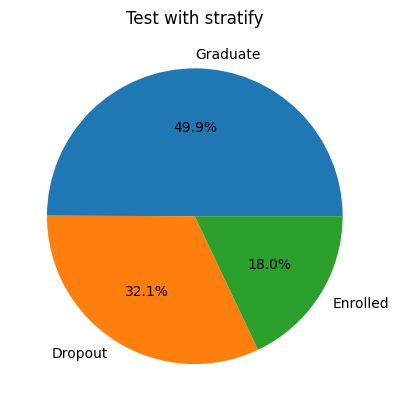

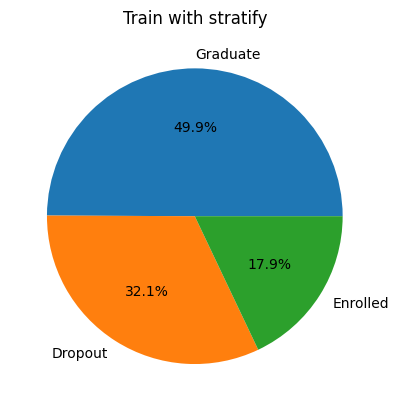

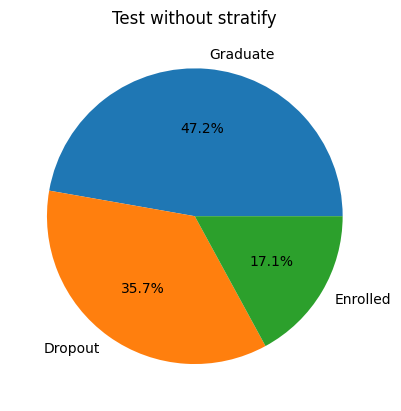

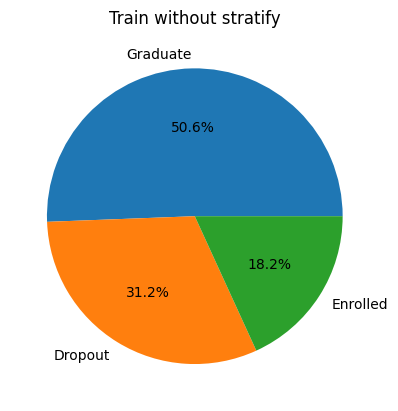

In [17]:
df = pd.read_csv("../Data/adjusted_data.csv", sep=';')
X = df.drop("Target", axis=1)
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(X)
X = pd.DataFrame(encoder.transform(X).toarray(), columns=encoder.get_feature_names_out(X.columns))
# Use a 1D target array (LogisticRegression expects y to be 1D for multiclass)
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
target = y_test.value_counts()
plt.pie(target, labels=target.index, autopct='%1.1f%%')
plt.title('Test with stratify')
plt.show()
target = y_train.value_counts()
plt.pie(target, labels=target.index, autopct='%1.1f%%')
plt.title('Train with stratify')
plt.show()

df = pd.read_csv("../Data/adjusted_data.csv", sep=';')
X = df.drop("Target", axis=1)
encoder = OneHotEncoder(handle_unknown="ignore")
encoder.fit(X)
X = pd.DataFrame(encoder.transform(X).toarray(), columns=encoder.get_feature_names_out(X.columns))
# Use a 1D target array (LogisticRegression expects y to be 1D for multiclass)
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target = y_test.value_counts()
plt.pie(target, labels=target.index, autopct='%1.1f%%')
plt.title('Test without stratify')
plt.show()
target = y_train.value_counts()
plt.pie(target, labels=target.index, autopct='%1.1f%%')
plt.title('Train without stratify')
plt.show()

Accuracy: 0.7129943502824859

Classification report:
               precision    recall  f1-score   support

     Dropout       0.77      0.70      0.73       316
    Enrolled       0.41      0.37      0.39       151
    Graduate       0.77      0.85      0.81       418

    accuracy                           0.71       885
   macro avg       0.65      0.64      0.64       885
weighted avg       0.71      0.71      0.71       885



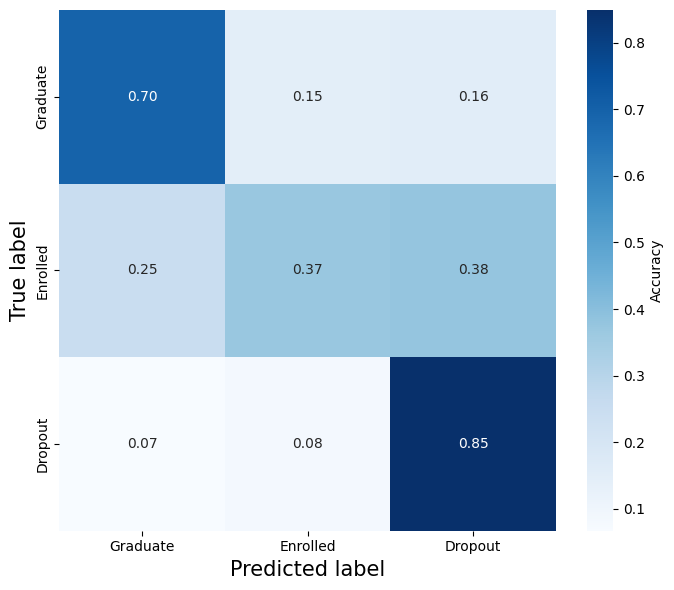

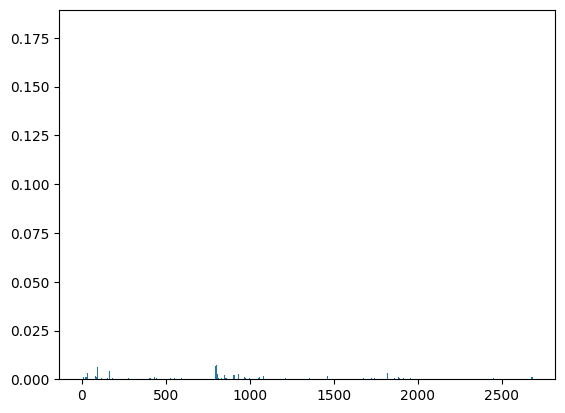

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

X = df.drop("Target", axis=1)
y = df["Target"]
#y = pd.get_dummies(y)
#print(y.head())
# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore")
# Assume for simplicity all features are categorical.
encoder.fit(X) 
# Apply the encoder.
X = encoder.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
# evaluate
y_pred = tree_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
# Confusion matrix from scikit-learn
cm = confusion_matrix(y_test, y_pred)

clothing = ['Graduate', 'Enrolled', 'Dropout']

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=clothing,
            yticklabels=clothing, cbar_kws={'label':'Accuracy'})
plt.xlabel("Predicted label", fontsize=15)
plt.ylabel("True label", fontsize=15)
plt.tight_layout()
#plt.savefig('../Figures/Fashion_MNIST_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
# Get importance
importance = tree_clf.feature_importances_
# Summarize feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

/tmp/ipykernel_53148/2538445988.py:31: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/home/manuela/miniconda3/envs/fys-course/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


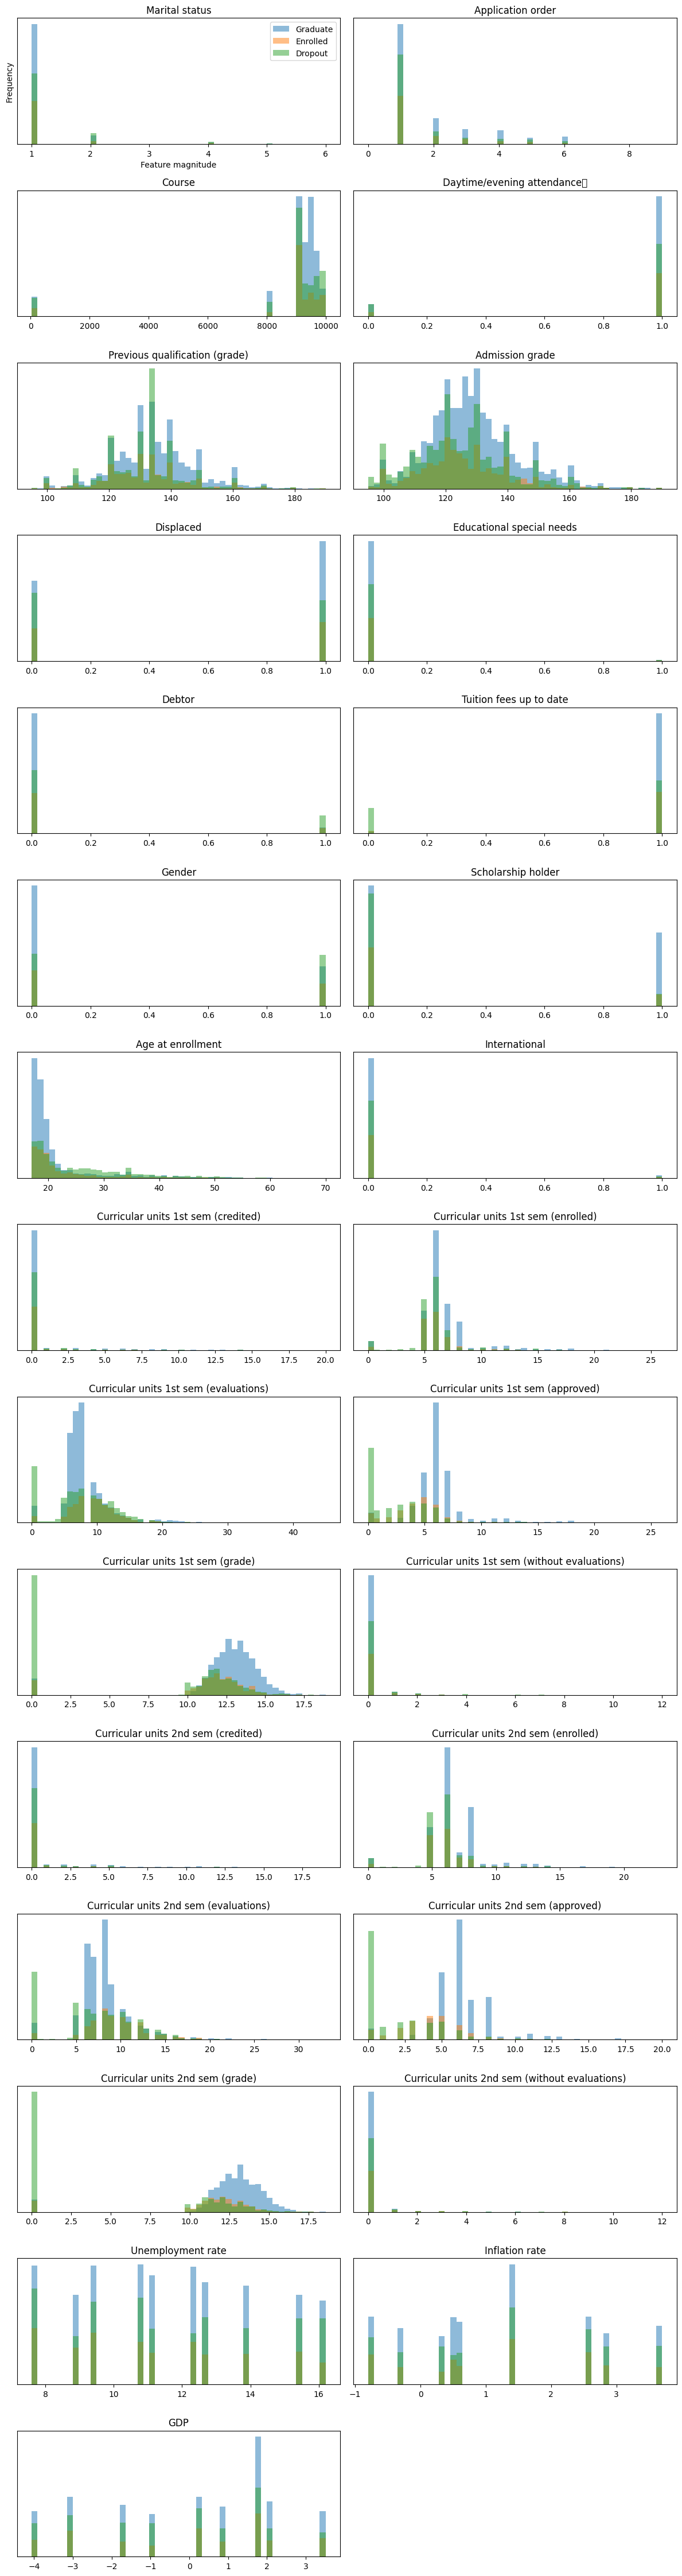

/home/manuela/miniconda3/envs/fys-course/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/manuela/miniconda3/envs/fys-course/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


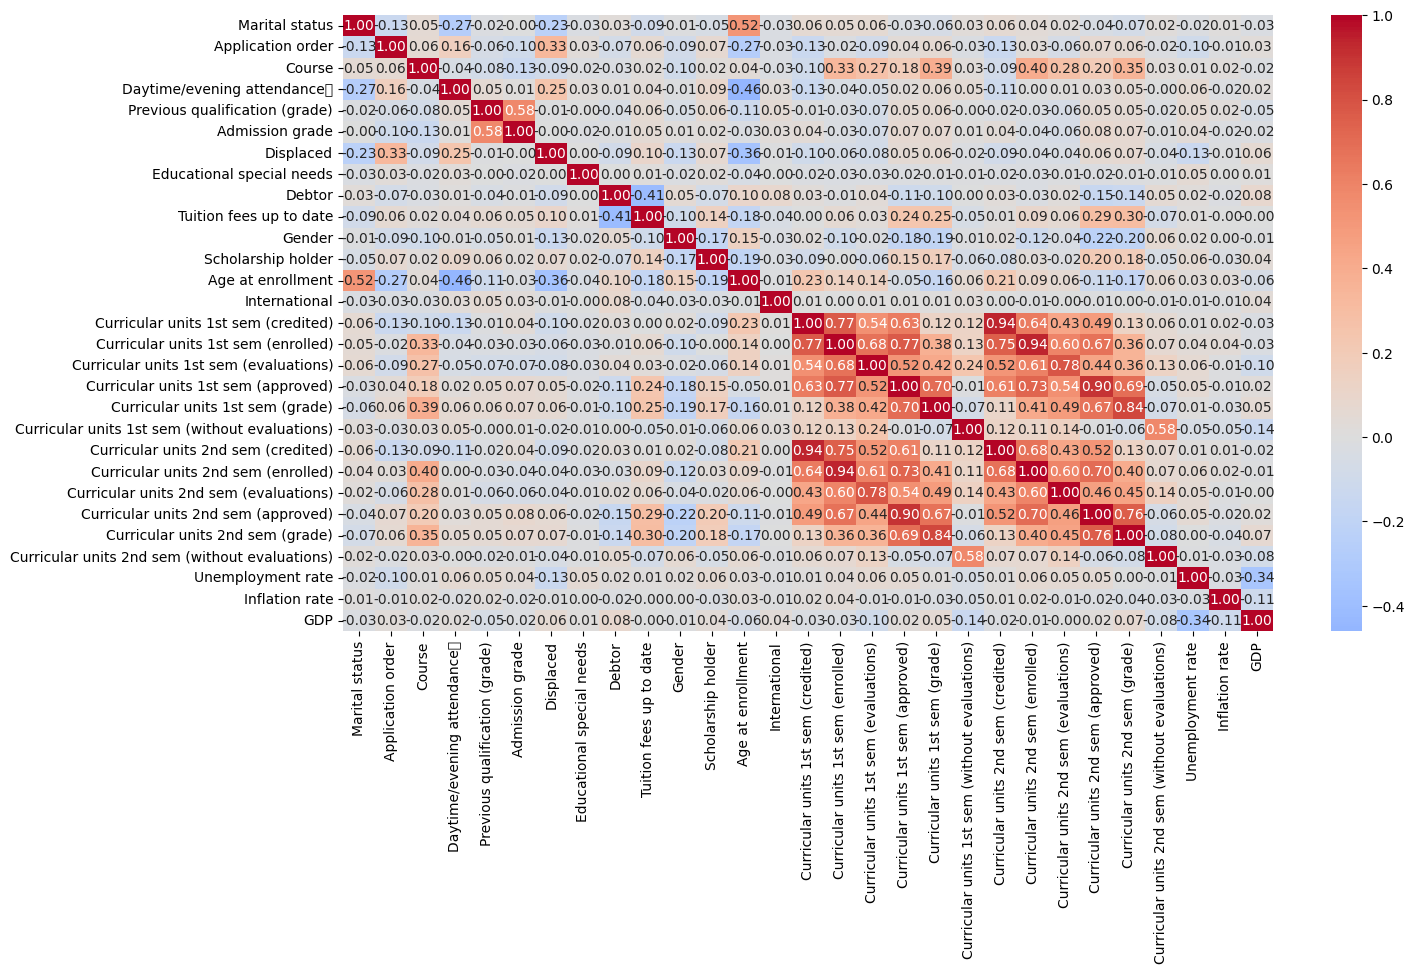

In [19]:
# plot numeric feature distributions by Target (up to 30 features) and correlation heatmap
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
features = numeric_features[:30]

nrows = (len(features) + 1) // 2
fig, axes = plt.subplots(nrows, 2, figsize=(12, 3 * nrows))
ax = axes.ravel()

graduate = df.loc[df['Target'] == 'Graduate', features]
enrolled = df.loc[df['Target'] == 'Enrolled', features]
dropout = df.loc[df['Target'] == 'Dropout', features]

for i, feat in enumerate(features):
    col_data = df[feat].dropna()
    if col_data.empty:
        ax[i].axis('off')
        continue
    bins = np.histogram(col_data, bins=50)[1]
    ax[i].hist(graduate[feat].dropna(), bins=bins, alpha=0.5)
    ax[i].hist(enrolled[feat].dropna(), bins=bins, alpha=0.5)
    ax[i].hist(dropout[feat].dropna(), bins=bins, alpha=0.5)
    ax[i].set_title(feat)
    ax[i].set_yticks([])
# turn off any unused subplots
for j in range(len(features), len(ax)):
    ax[j].axis('off')

ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["Graduate", "Enrolled", "Dropout"], loc="best")
fig.tight_layout()
plt.show()

# correlation heatmap (use numeric features)
corr = df[features].corr().round(2)
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.show()